In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist # fonctions pour charger et tracer les données
import numpy as np

import matplotlib.pyplot as plt



In [2]:
# Chargement et transformation des données

p = 28

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
# Déf de l'Encodeur et du Decodeur - A compléter

class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        # Code à compléter avec la définition des couches de l'encodeur ------------------------------------------------------------------------------
        self.fc1 = nn.Linear(p**2, latent_size)  
        self.activation = nn.Sigmoid()  

    def forward(self, x):
        # Code à compléter avec la passe forward de l'encodeur ----------------------------------------------------------------------------------------
        x=self.fc1(x)
        x=self.activation(x)
        return x
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        # Code à compléter avec la définition des couches du décodeur ---------------------------------------------------------------------------------
        self.fc1 = nn.Linear( latent_size,p**2)  
        self.activation = nn.Sigmoid()  
        
    def forward(self, x):
        # Code à compléter avec la passe forward du décodeur -------------------------------------------------------------------------------------------
        x=self.fc1(x)
        x=self.activation(x)
        return x

In [4]:
# Déf de l'AE --- A compléter

class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, p*p)
        h = self.E(x)
        self.data_rho = h.mean(0) # calculates rho from encoder activations
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):        
        dkl = rho * torch.log(rho / self.data_rho) + (1 - rho) * torch.log((1 - rho) / (1 - self.data_rho))
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, p*p)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [16]:
# Définition du modèle à tester (on peut même entraîner plusieurs à la fois en définissant models correctement)

# Dimension de l'espace latent (z)
lat_dim = 128
models = {str(lat_dim): Net(lat_dim)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [17]:
# Fonction pour l'entraînement

def train(epoch, models, log=None, add_noise=False, half_image=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            if add_noise:
                inputs = noise_batch(inputs)
            if half_image:
                inputs = half_batch(inputs)
            output = model(inputs)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = "Époque : {} [{}/{} ({:.0f}%)]\tPertes ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = "Époque : {} [{}/{} ({:.0f}%)]\tPertes ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: "perte: {:.4f}".format(l)
rho_lambda = lambda p: "régularisation: {:.4f}".format(p)
line = lambda i, l, p: "{}: ".format(i) + avg_lambda(l) + "\t" + rho_lambda(p)
  
# Fonction de test
    
def test(models, loader, log=None, add_noise=False, half_image=False):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            inputs = data.clone().detach()
            if add_noise:
                inputs = noise_batch(inputs)
            if half_image:
                inputs = half_batch(inputs)
            output = {k: m(inputs) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction="sum").item()
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * p**2)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = "\n".join([line(k, test_loss[k], rho_loss[k]) for k in models]) + "\n"
    report = "Jeu de test :\n" + lines        
    print(report)

In [19]:
Nepochs = 10
# Entrainement
for epoch in range(1, 1+Nepochs):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Époque : 1 [0/50000 (0%)]	Pertes 128: 1.919335
Époque : 1 [10000/50000 (20%)]	Pertes 128: 1.753451
Époque : 1 [20000/50000 (40%)]	Pertes 128: 1.270147
Époque : 1 [30000/50000 (60%)]	Pertes 128: 1.145984
Époque : 1 [40000/50000 (80%)]	Pertes 128: 1.085757
Époque : 1 [50000/50000 (100%)]	Pertes 128: 1.053858
Jeu de test :
128: perte: 1.0545	régularisation: 0.0032

Époque : 2 [0/50000 (0%)]	Pertes 128: 1.061102
Époque : 2 [10000/50000 (20%)]	Pertes 128: 1.034532
Époque : 2 [20000/50000 (40%)]	Pertes 128: 1.021651
Époque : 2 [30000/50000 (60%)]	Pertes 128: 1.008367
Époque : 2 [40000/50000 (80%)]	Pertes 128: 0.996381
Époque : 2 [50000/50000 (100%)]	Pertes 128: 0.993072
Jeu de test :
128: perte: 0.9946	régularisation: 0.0021

Époque : 3 [0/50000 (0%)]	Pertes 128: 0.997297
Époque : 3 [10000/50000 (20%)]	Pertes 128: 0.984832
Époque : 3 [20000/50000 (40%)]	Pertes 128: 0.979480
Époque : 3 [30000/50000 (60%)]	Pertes 128: 0.970382
Époque : 3 [40000/50000 (80%)]	Pertes 128: 0.973231
Époque : 3 [500

Tracée de la perte sur les données de test au cours des époques (utile pour détecter un surajustement):

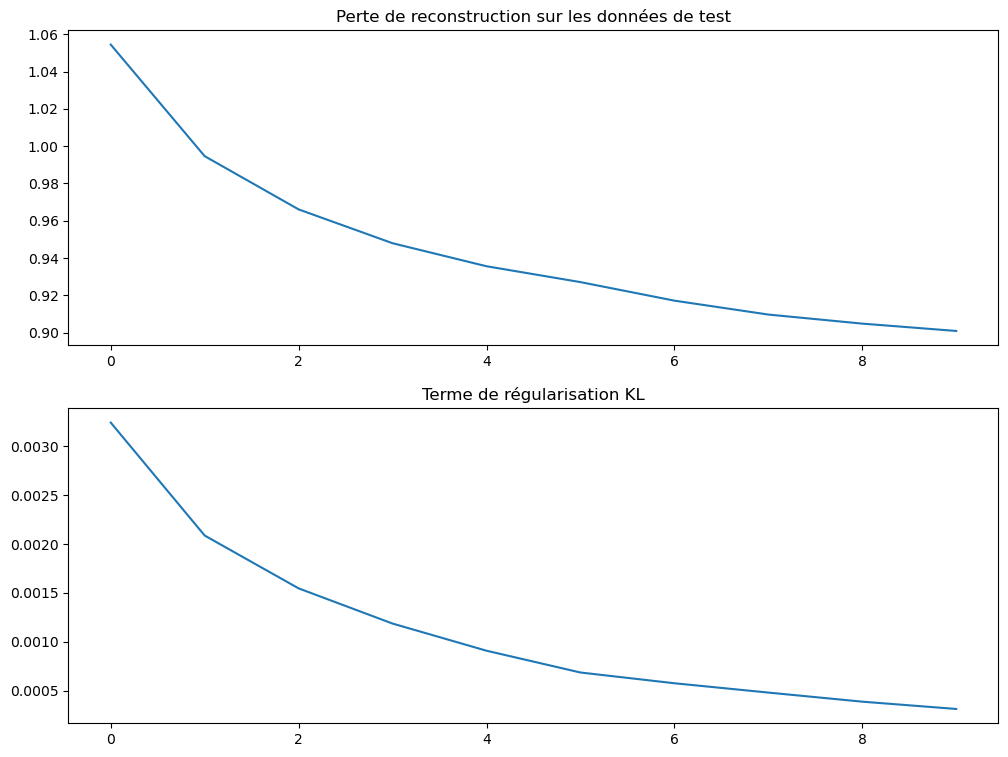

In [20]:
fig, ax = plt.subplots(2, figsize=(12,9))
ax[0].plot(np.array(test_log[str(lat_dim)])[:,0])
ax[0].set_title("Perte de reconstruction sur les données de test")
ax[1].plot(np.array(test_log[str(lat_dim)])[:,1])
ax[1].set_title("Terme de régularisation KL")
plt.show()

Test du modèle sur différents types d'entrée :

1. Reconstruction d'un jeu d'images de l'ensemble de test ;
2. Décodage de vecteurs z appartenant à la base canonique (donc maximalement parcimonieux) ;
3. On compte le nombre d'unités de z dont l'activation est > 1/2. Ensuite, on met à zéro les activations inférieurs à 1/2 et on trace la reconstruction.

In [21]:
data, _ = next(iter(test_loader))

#(1.)
output = models[str(lat_dim)](data)
to_plot = output.view(-1, 1, p, p).clamp(0, 1).data.numpy()

#(2.)
decoded = models[str(lat_dim)].decode(torch.eye(lat_dim))
dec_to_plot = ((decoded.view(-1, 1, p, p)+1)*0.5).clamp(0, 1).data.numpy()
dec_to_plot = dec_to_plot[:256]
with torch.no_grad():
    encoded = models[str(lat_dim)].E(data.view(-1, p*p))
    
    #(3.)
    print("Nombre d'unités avec activation > 1/2 :\n", (encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.    
    decoded_f = models[str(lat_dim)].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, p, p)+1)*0.5).clamp(0, 1).data.numpy()

Nombre d'unités avec activation > 1/2 :
 tensor([ 6,  9,  7,  8,  9,  8,  5,  7,  2,  5, 10,  4,  7,  9,  9,  8,  7,  8,
         9,  7,  7,  9,  7,  9,  3,  8,  7,  8,  8,  8,  7,  9,  8,  7,  5, 10,
         8,  7,  4,  9,  7,  6,  7,  6,  9,  6,  7,  6,  8,  9])


Jeu d'images de test et leurs reconstructions :

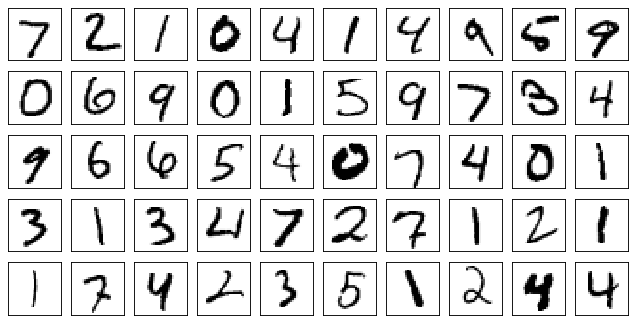

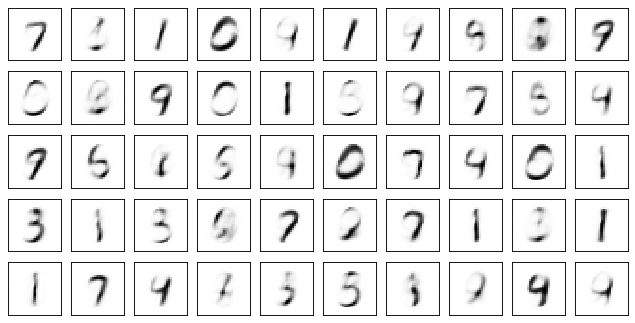

In [22]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))

Reconstruction des mêmes images, cette-fois ci après avoir mis à zéro les composantes des respectifs codes dont la valeur < 1/2.

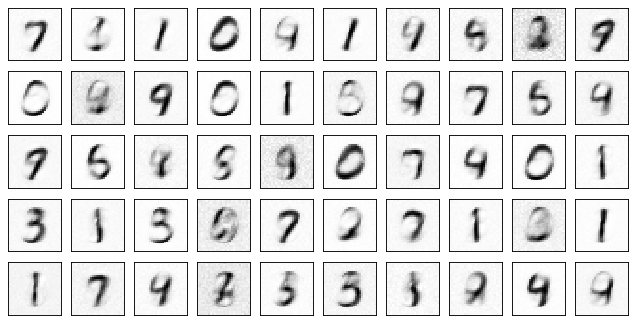

In [23]:
plot_mnist(f_to_plot, (5, 10))

Résultat du décodeur appliqué à des vecteurs de la base canonique (donc maximalement parcimonieux, avec une seule composante non nulle).

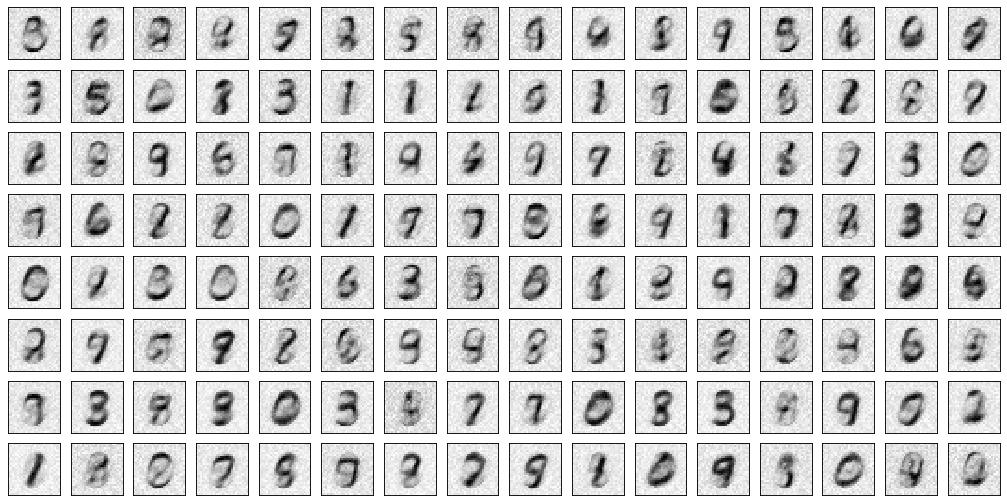

In [24]:
plot_mnist(dec_to_plot, (16, 16))